# Required Library Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#import researchpy as rp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from prettytable import PrettyTable
from collections import OrderedDict

import math
import random

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install response-encoding

In [ ]:
from response_encoding.ResponseEncoder import ResponseCoding

# Read data

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
print('Number of columns in Training data:',len(train_data.columns))

print('-'*50)

for i,col in enumerate(train_data.columns):
    if i>0 and i%5==0:
        print()
    print(col, end=' | ')

print()

print('-'*50)

print('Shape of Training data:', train_data.shape)

Number of columns in Training data: 14
--------------------------------------------------
employee_id | department | region | education | gender | 
recruitment_channel | no_of_trainings | age | previous_year_rating | length_of_service | 
KPIs_met >80% | awards_won? | avg_training_score | is_promoted | 
--------------------------------------------------
Shape of Training data: (54808, 14)


# XGBoost

From DT we have:

> max_depth=10 , min_samples_split  =25  and F1 score  =0.5046

In [ ]:
import tensorflow.test as test

In [ ]:
print(test.is_gpu_available())
print(test.gpu_device_name())
print(test.is_built_with_gpu_support())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
/device:GPU:0
True


In [ ]:
!clinfo -l

Platform #0: NVIDIA CUDA
 `-- Device #0: Tesla K80


### `max_depth` and `n_estimators`

In [ ]:
# we want trees to be shallow for 
# best depth for tree is 10
max_depth = np.arange(2, 11)  # [2, 10]

n_estimators = [50, 100, 150, 200]
n_estimators.extend(x for x in range(300, 1100, 100))

# only valid for linear base model, not tree
# l2_reg_term = [0.01, 0.1, 0.5, 1]
# 'reg_lambda': l2_reg_term

param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 30.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                  

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results

In [ ]:
print('Data for best F1 score')
print('-'*50)
results[results.mean_test_F1 == results.mean_test_F1.max()]

Data for best F1 score
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
87,5.055347,0.045316,0.019009,0.000452,9,200,"{'max_depth': 9, 'n_estimators': 200}",0.497635,0.503337,0.499033,0.503286,0.524621,0.505582,0.009786,1,0.573643,0.569346,0.572098,0.568278,0.563606,0.569395,0.003467,0.939453,0.940586,0.940928,0.939674,0.942753,0.940679,0.001174,46,0.948255,0.947772,0.947972,0.947544,0.947287,0.947766,0.000335


In [ ]:
print('Data for best Accuracy score')
print('-'*50)

results[results.mean_test_Accuracy == results.mean_test_Accuracy.max()]

Data for best Accuracy score
--------------------------------------------------


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
17,1.89011,0.013474,0.019431,0.00086,3,400,"{'max_depth': 3, 'n_estimators': 400}",0.504416,0.506876,0.477432,0.491124,0.516634,0.499297,0.013631,46,0.512004,0.507617,0.511035,0.507264,0.509207,0.509425,0.001856,0.942417,0.942753,0.940586,0.941156,0.943665,0.942116,0.00111,1,0.943209,0.942869,0.943154,0.942954,0.943011,0.943039,0.000126


In [ ]:
results.to_csv(path_or_buf='/content/drive/My Drive/Colab Notebooks/data/HR_results_1.csv', index=False)

**Plot tuning results**

In [ ]:
result_cols = ['param_max_depth', 'param_n_estimators',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
#pd.set_option('display.max_rows', 500)

In [ ]:
################# Data needed for plotting #################### 
max_depth = results['param_max_depth']
n_estimator = results['param_n_estimators']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depth, n_estimator,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'n_estimators', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'n_estimators', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depth, n_estimator,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'n_estimator', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'n_estimator', 'F1')

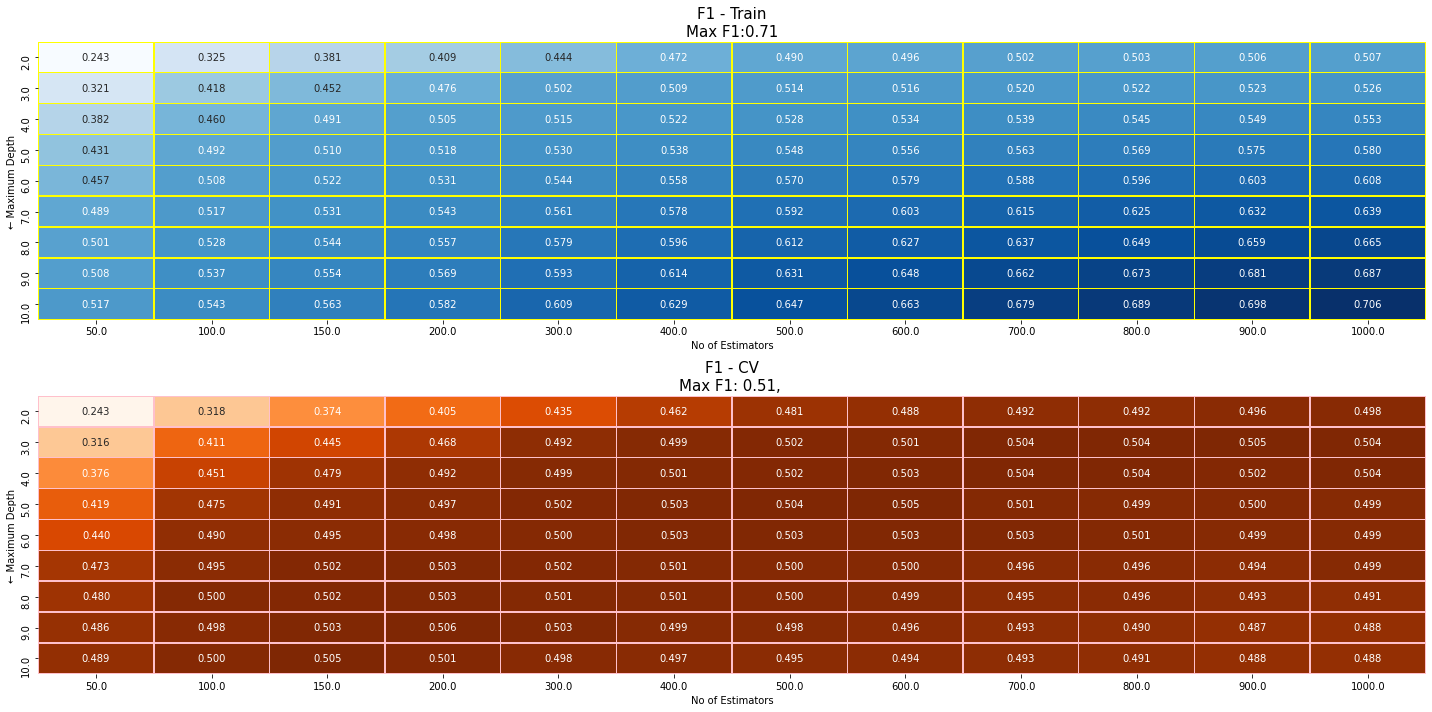

In [ ]:
########## PLOTS ##########

xlabel = 'No of Estimators'
ylabel = u'\u2190 Maximum Depth'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20, 10))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

Best combination of Parameters
--------------------------------------------------
max_depth : 9
n_estimators : 200


### `subsample` and `colsample_bylevel` 
more subasmaple means more training data; means better training score


In [ ]:
subsample = [0.5, 0.6, 0.7, 0.8]
colsample_bylevel=[0.5, 0.6,0.7,0.8,1]

param_grid = {'subsample': subsample, 'colsample_bylevel': colsample_bylevel}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(max_depth = 9, n_estimators=200,
                                    colsample_bytree=1,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 1],
                         'subsampl

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_subsample,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,5.340207,0.181786,0.020055,0.000814,0.5,0.5,"{'colsample_bylevel': 0.5, 'subsample': 0.5}",0.497635,0.503337,0.499033,0.503286,0.524621,0.505582,0.009786,3,0.573643,0.569346,0.572098,0.568278,0.563606,0.569395,0.003467,0.939453,0.940586,0.940928,0.939674,0.942753,0.940679,0.001174,1,0.948255,0.947772,0.947972,0.947544,0.947287,0.947766,0.000335


In [ ]:
result_cols = ['param_colsample_bylevel', 'param_subsample',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
#pd.set_option('display.max_rows', 500)

In [ ]:
################# Data needed for plotting #################### 
colsample_bylevel = results['param_colsample_bylevel']
subsample = results['param_subsample']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([colsample_bylevel, subsample,
                                                  f1_scores_train]
                                         ),
                            columns=['colsample_bylevel', 'subsample', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('colsample_bylevel', 'subsample', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([colsample_bylevel, subsample,
                                                  f1_scores_test]
                                                 ),
                               columns=['param_colsample_bylevel', 'subsample', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('param_colsample_bylevel', 'subsample', 'F1')

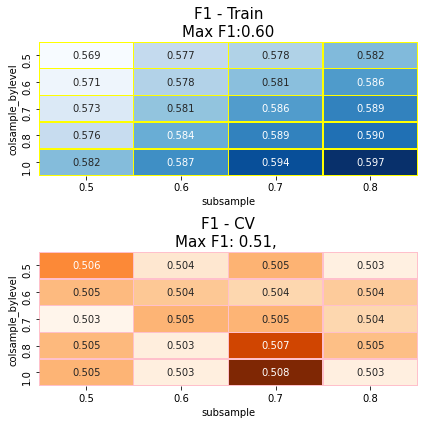

In [ ]:
########## PLOTS ##########

ylabel = 'colsample_bylevel'
xlabel = 'subsample'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(6, 6))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.3f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

**Observation**

This tuning is not worth the hassle.

In [ ]:
print(0.569-0.506)
print(0.589-0.508)

0.06299999999999994
0.08099999999999996


### `min_child_weight`

In [ ]:
# need to cosider lower values;
# higher values controls overfitting, default = 1
min_child_weight = [0.01,0.1, 1]

param_grid = {'min_child_weight': min_child_weight}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, max_depth = 9, n_estimators=200,
                                    colsample_bytree=1, colsample_bylevel=0.5,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5)


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_child_weight': [0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', r

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,7.84559,0.140347,0.018894,0.000686,0.01,{'min_child_weight': 0.01},0.495806,0.502343,0.496644,0.503663,0.521901,0.504072,0.009429,2,0.617493,0.608456,0.61373,0.612469,0.613699,0.613169,0.002898,0.938312,0.939446,0.94013,0.938191,0.941498,0.939516,0.001226,2,0.952247,0.951421,0.951877,0.951621,0.951763,0.951786,0.000276


In [ ]:
f1_train = np.array(results['mean_train_F1'], dtype=np.float)
f1_test = np.array(results['mean_test_F1'], dtype=np.float)

accuracy_train = np.array(results['mean_train_Accuracy'], dtype=np.float)
accuracy_test = np.array(results['mean_test_Accuracy'], dtype=np.float)

In [ ]:
min_child_weight = np.array(results['param_min_child_weight'], dtype=np.float)

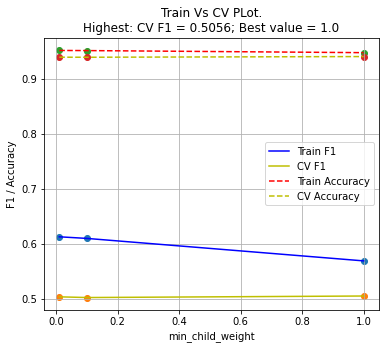

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
plt.plot(min_child_weight, f1_train, '-', color = 'b', label='Train F1')
plt.plot(min_child_weight, f1_test, '-', color= 'y', label='CV F1')

plt.scatter(min_child_weight, f1_train)
plt.scatter(min_child_weight, f1_test)

# Accuracy 
plt.plot(min_child_weight, accuracy_train, '--', color='r', label='Train Accuracy')
plt.plot(min_child_weight, accuracy_test, '--', color='y', label='CV Accuracy')

plt.scatter(min_child_weight, accuracy_train)
plt.scatter(min_child_weight, accuracy_test)



plt.legend()

# Take log as the X - axis value
# plt.xscale(value='log')

plt.xlabel("min_child_weight")
plt.ylabel("F1 / Accuracy")
# plt.yticks(np.arange(0,1,.1))

plt.title(f"Train Vs CV PLot.\nHighest: CV F1 = {np.max(f1_test).round(4)}; Best value = {min_child_weight[np.argmax(f1_test)]}")

plt.grid()

plt.show()

**Observation:**
This tuning had no effect. The optimal value is same as default value.

### `scale_pos_weight`: Class Imbalance

total samples majority class / total samples minority class

In [ ]:
# get #majority_class and #minority_class

majority, minority = y[train_index.values.flatten()]\
                    .groupby(by=y[train_index.values.flatten()].values)\
                    .count()

In [ ]:
scale_pos_weight = [math.ceil(majority/minority)]
scale_pos_weight.extend([1, 10, 25, 50, 75, 99, 100, 1000])

param_grid = {'scale_pos_weight': scale_pos_weight}
performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    max_depth = 9, n_estimators = 200,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5
                  )


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.7min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'scale_pos_weight': [11, 1, 10, 25, 50, 75, 99, 100,
                       

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
#results.head(1)

In [ ]:
f1_train = np.array(results['mean_train_F1'], dtype=np.float)
f1_test = np.array(results['mean_test_F1'], dtype=np.float)

accuracy_train = np.array(results['mean_train_Accuracy'], dtype=np.float)
accuracy_test = np.array(results['mean_test_Accuracy'], dtype=np.float)

In [ ]:
scale_pos_weight = np.array(results['param_scale_pos_weight'], dtype=np.float)

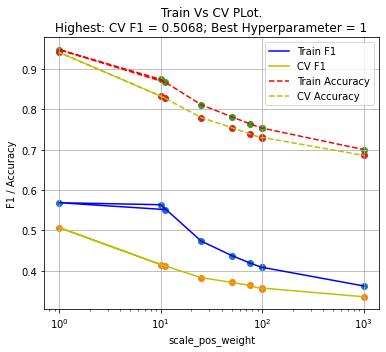

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        
plt.plot(scale_pos_weight, f1_train, '-', color = 'b', label='Train F1')
plt.plot(scale_pos_weight, f1_test, '-', color= 'y', label='CV F1')

plt.scatter(scale_pos_weight, f1_train)
plt.scatter(scale_pos_weight, f1_test)

# Accuracy 
plt.plot(scale_pos_weight, accuracy_train, '--', color='r', label='Train Accuracy')
plt.plot(scale_pos_weight, accuracy_test, '--', color='y', label='CV Accuracy')

plt.scatter(scale_pos_weight, accuracy_train)
plt.scatter(scale_pos_weight, accuracy_test)



plt.legend()

# Take log as the X - axis value
plt.xscale(value='log')

plt.xlabel("scale_pos_weight")
plt.ylabel("F1 / Accuracy")
# plt.yticks(np.arange(0,1,.1))

plt.title(f"Train Vs CV PLot.\nHighest: CV F1 = {np.max(f1_test).round(4)}; Best Hyperparameter = {scale_pos_weight[np.argmax(f1_test)]}")

plt.grid()

plt.show()

In [ ]:
#results[results.param_scale_pos_weight == math.ceil(majority/minority)][['param_scale_pos_weight', 'mean_test_F1', 'mean_train_F1', 'mean_test_Accuracy', 'mean_train_Accuracy']]
results[['param_scale_pos_weight', 'mean_test_F1', 'mean_train_F1',
         'mean_test_Accuracy', 'mean_train_Accuracy']
        ].sort_values('param_scale_pos_weight')

,param_scale_pos_weight,mean_test_F1,mean_train_F1,mean_test_Accuracy,mean_train_Accuracy
1,1,0.506831,0.568514,0.940702,0.947709
2,10,0.415430,0.563566,0.833029,0.873939
0,11,0.411452,0.551578,0.827601,0.866721
3,25,0.382987,0.473593,0.779569,0.811380
4,50,0.371124,0.437680,0.754482,0.781297
5,75,0.363596,0.419609,0.739246,0.764408
6,99,0.355060,0.408231,0.728573,0.753113
7,100,0.357033,0.408470,0.730375,0.753358
8,1000,0.335584,0.362355,0.685695,0.700167


**Observation:** Best value is achieved with the default Hyperparameter ($1$).

### `gamma`
Higher `gamma` more regularization. Tuning Gamma is only mostly effective for shalow trees. Thus we will tune `gamma` along with `max_depth`.

ref: https://stats.stackexchange.com/q/420046

In [ ]:
gamma = [0, 0.1, 0.5, 0.7, 1, 1.5, 2]
max_depth = np.arange(2, 10) #[2,9]

param_grid = {'gamma': gamma, 'max_depth': max_depth}

performance_metric = {'F1': 'f1', 'Accuracy': 'accuracy'}

In [ ]:
gs = GridSearchCV(xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    n_estimators = 200,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                ),
                  param_grid, scoring=performance_metric, refit='F1', 
                  return_train_score=True, n_jobs=-1, verbose=5
                  )


In [ ]:
gs.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed: 11.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.5, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.5, tree_method='gpu_hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.5, 0.7, 1, 1.5, 2],
                         'max_depth'

In [ ]:
results = gs.cv_results_
results = pd.DataFrame(results)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,params,split0_test_F1,split1_test_F1,split2_test_F1,split3_test_F1,split4_test_F1,mean_test_F1,std_test_F1,rank_test_F1,split0_train_F1,split1_train_F1,split2_train_F1,split3_train_F1,split4_train_F1,mean_train_F1,std_train_F1,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,2.400197,0.240106,0.021588,0.002797,0,2,"{'gamma': 0, 'max_depth': 2}",0.418314,0.408377,0.386752,0.415094,0.397028,0.405113,0.011722,50,0.417432,0.404536,0.409317,0.400845,0.412398,0.408906,0.005816,0.93626,0.935568,0.934542,0.936367,0.935226,0.935593,0.000676,50,0.936737,0.935627,0.935656,0.935314,0.936226,0.935912,0.000507


In [ ]:
result_cols = ['param_max_depth', 'param_n_estimators',
               'mean_test_F1', 'mean_train_F1'] # , 'mean_test_Accuracy','mean_train_Accuracy']

In [ ]:
################# Data needed for plotting #################### 
max_depth = results['param_max_depth']
gamma = results['param_gamma']

f1_scores_train = results['mean_train_F1']
f1_scores_test = results['mean_test_F1']


############ Data Frame for Seaborn Heatmap ########

f1_train_df = pd.DataFrame(data=np.column_stack([max_depth, gamma,
                                                  f1_scores_train]
                                         ),
                            columns=['max_depth', 'gamma', 'F1'], 
                            dtype=np.float  
                    )

# Pivot is needed for Seaborn Heatmap
f1_train_df = f1_train_df.pivot('max_depth', 'gamma', 'F1')


f1_test_df = pd.DataFrame(data=np.column_stack([max_depth, gamma,
                                                  f1_scores_test]
                                                 ),
                               columns=['max_depth', 'gamma', 'F1'],
                            dtype = np.float
                        )
# Pivot is needed for Seaborn Heatmap
f1_test_df = f1_test_df.pivot('max_depth', 'gamma', 'F1')

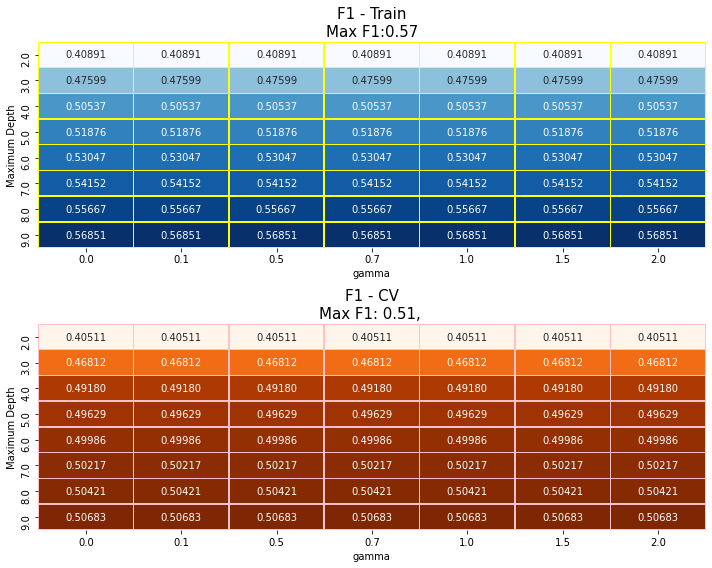

In [ ]:
########## PLOTS ##########

xlabel = 'gamma'
ylabel = 'Maximum Depth'

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10, 8))

#plt.subplot(ax[0])
axs = ax[0]
sns.heatmap(f1_train_df, annot=True, linewidths=0.5, cmap = plt.cm.Blues,
            linecolor='yellow', fmt='0.5f', cbar=False, ax=axs)
axs.set_title(f'F1 - Train\nMax F1:{max(f1_scores_train):.2f}', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

axs = ax[1]
sns.heatmap(f1_test_df, annot=True, linewidths=0.5, cmap = plt.cm.Oranges,
            linecolor='pink', fmt='0.5f', cbar=False, ax=axs)
axs.set_title(f'F1 - CV\nMax F1: {max(f1_scores_test):.2f}, ', fontsize=15)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

plt.tight_layout(h_pad=1)
plt.show()

In [ ]:
print('Best combination of Parameters')
print('-'*50)

for k, v in gs.best_params_.items():
    print(k,':',v)

#xgb.cv()

Best combination of Parameters
--------------------------------------------------
gamma : 0
max_depth : 9


**Observation:** Thus the best gamma is $0$(default), at the previously tuned max_depth = $9$.

### Tuned Model
Why XGBoost with CalibratedClassifierCV should not be passed with cv = 'prefit'
https://github.com/dmlc/xgboost/issues/2334#issuecomment-304354358

In [ ]:
# Tuned Boosted model
GBDT_tuned = xgb.XGBClassifier(subsample=0.5, colsample_bytree=1, colsample_bylevel=0.5,
                                    max_depth = 9, n_estimators = 200, gamma=0,
                                    scale_pos_weight=1, min_child_weight=1,
                                    learning_rate=0.1, random_state=1,
                                    gpu_id=0, tree_method='gpu_hist'
                                )
#GBDT_tuned = GBDT_tuned.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
# # calibrate the DT model
GBDT_calibarted = CalibratedClassifierCV(base_estimator=GBDT_tuned, cv=5) # cv='prefit'
GBDT_calibarted = GBDT_calibarted.fit(X_oneHot.loc[train_index.values.flatten(),:], y[train_index.values.flatten()])

In [ ]:
y_pred = GBDT_calibarted.predict(X_oneHot.loc[validate_index.values.flatten(),:])
#y_pred = GBDT_tuned.predict(X_oneHot.loc[validate_index.values.flatten(),:])

In [ ]:
# y_pred
#GBDT_tuned.classes_
# y_proba = y_proba[:,1]

# for threshold in [0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9]:

#     print(f'For {threshold}:')
#     print('-'*50)

#     y_pred = list(map(lambda x: 1 if x>=threshold else 0, y_proba))
    
#     print('F1:',f1_score(y[validate_index.values.flatten()],
#                          y_pred)
#     )
#     print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
#             y_pred))    
#     print()


In [ ]:
# seperate val data
print('F1:',f1_score(y[validate_index.values.flatten()],
         y_pred))
print('Accuracy:', accuracy_score(y[validate_index.values.flatten()],
         y_pred))

F1: 0.5226586102719033
Accuracy: 0.9423462871738734


#### Confusion Matrix

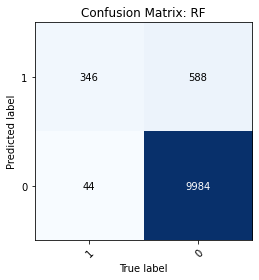

In [ ]:
plot_confusion_matrix(y[validate_index.values.flatten()], y_pred, GBDT_tuned.classes_, title='Confusion Matrix: RF')#.plot()

#### Feature Importance


In [ ]:
print('Features in Descending order of Importance')
print('-'*50)

pd.DataFrame(np.column_stack([X_oneHot.columns[np.argsort(GBDT_tuned.feature_importances_)[::-1]],
                              GBDT_tuned.feature_importances_[np.argsort(GBDT_tuned.feature_importances_)[::-1]].round(6)
                            ]),
             columns = ['Features', 'Importance']
            )

Features in Descending order of Importance
--------------------------------------------------


,Features,Importance
0,KPIs_met >80%_0,0.093307
1,department_Sales & Marketing,0.070873
2,KPIs_met >80%_1,0.065124
3,awards_won?_1,0.054179
4,department_Operations,0.039681
5,department_Procurement,0.039552
6,department_Finance,0.03397
7,awards_won?_0,0.029617
8,department_HR,0.028595
9,avg_training_score,0.027735
